# Задание - взвешенный учет людей в стилизации
Модификация [классического переноса стиля Gatys et al. (2016) Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html)

Задание необходимо сдать до 8 ноября 23:30.
12 баллов.

Скачать предобученную модель VGG вы можете командами:

mkdir Models && cd Models

wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth

cd ..

# Описание
Как известно, нейросетевая стилизация способна накладывать сложные стили, но ценой искажения исходного изображения. Ваша задача - реализовать метод, который бы накладывал стиль максимально выраженно, но стилизация людей осуществлялась бы **с меньшей силой**, чтобы сохранить их узнаваемость. 

Вам необходимо:

1. **Реализовать стилевую функцию потерь (2 балла)**, вычисляющую нецентрированную матрицу Грамма (попарные ковариации между каналами, не забудьте поделить на height*width тензора) и квадрат нормы Фробениуса для расхождения матриц Грамма. Это 2 блока "YOUR CODE HERE" в коде ниже.  

1. **Учитывать пространственный вес при ф-ции сохранения контента (content loss) взвешенной, согласно карте весов (2 балла).**
Карта весов имеет размер HxW (пространственные размеры тензора, на котором вычисляется ф-ция потерь контента). 

1. **Выделить людей, а на людях - кожу по результатам сегментации (8 баллов).**
Карту весов инициализировать малой константой для фона, средней константой- для людей, большой константой - для кожи (лица и др. части тела без одежды). Явно продемонстрировать преимущество разного учета кожи, людей и фона.



## Оценивание

**Наличие вашего кода, реализующего все задания**
В процессе решения вы можете использовать любые готовые алгоритмы и решения **со ссылкой на первоисточник**. При модификации - указывать, что именно было модифицировано. Если код есть в первоисточнике и запускался отдельно, то его можно не вставлять. Обученные модели не присылать. Решения присылайте как закрытую ссылку на zip архив в файлообменнике, не через github и другие открытые источники. Название архива - Фамилия-Имя.zip на русском.

В конце ноутбука нужно 

1. **визуализировать стиль**

1. **привести таблицу изображений для каждого из 32 изображений контента (64 строки):** 

строка 1x3:
* контент
* результат сегментации (3 класса: кожа, люди, фон)
* карта весов

строка 1x2:
* стилизация стандартным алгоритмом
* стилизация стандартным алгоритмом+взвешивание по результатам сегментации

Стиль достаточно использовать любой и один, на котором преимущество модифицированного алгоритма заметнее. Например, можно воспользоваться [одним из этих](https://yadi.sk/d/X2liqQKsA1428A?w=1).
Изображения 32 контентов нужно брать [только отсюда](https://yadi.sk/d/EkCPi075Mlh0Lg?w=1). 



**Оценивание в первую очередь будет идти по указанным таблицам**, насколько явным будет преимущество предложенным алгоритмом, что зависит от
1. точности алгоритма сегментации людей
1. точности алгоритма сегментации кожи
1. грамотного подбора силы стилизации кожи (стилизуются немного), стилизации людей (стилизуются средне) и фона (стилизуется сильно)
1. обеспечения условия визуальной одинаковости стилизации базовым и модифицированным алгоритмом стилизации (коэффициент при функции потерь стиля для алгоритмов может быть разным).

Для каждого алгоритма **параметры должны быть зафиксированны**, а не подбираться индивидуально для каждого изображения. Веса при ф-циях потерь стиля, контента и учета контуров в рамках каждого алгоритма нужно подобрать так, чтобы сравнение алгоритмов производилось при одинаковой силе стилизации (взвешивание может изменить среднюю силу стилизации).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!wget -O /content/drive/My\ Drive/Colab\ Notebooks/Глубокое\ обучение/Models3/vgg_conv.pth -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth

--2020-11-08 23:52:27--  https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
Resolving bethgelab.org (bethgelab.org)... 46.38.232.246
Connecting to bethgelab.org (bethgelab.org)|46.38.232.246|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
%pylab inline
import time
import os 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

!pip3 install tensorflow
!pip3 install opencv-python
!pip3 install scikit-image
!pip3 install pillow
!pip3 install pixellib

import pixellib
from pixellib.semantic import semantic_segmentation
from natsort import natsorted
import os
from pixellib.instance import instance_segmentation
import cv2
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


In [6]:
!git clone https://github.com/WillBrennan/SkinDetector

fatal: destination path 'SkinDetector' already exists and is not an empty directory.


In [7]:
cd SkinDetector

/content/SkinDetector


In [8]:
!make install

pip install -U -r requirements.txt
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 1)) (0.35.1)
Requirement already up-to-date: pytest in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 2)) (6.1.2)
Requirement already up-to-date: sphinx in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 3)) (3.3.0)
  Using cached https://files.pythonhosted.org/packages/87/86/753182c9085ba4936c0076269a571613387cdb77ae2bf537448bfd63472c/numpy-1.19.4-cp36-cp36m-manylinux2010_x86_64.whl
Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 5)) (4.4.0.46)
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=

In [9]:
import cv2  
import skin_detector
from google.colab.patches import cv2_imshow

Алгоритм сегментации людей и лиц:

In [10]:
image_dir = '/content/drive/My Drive/Colab Notebooks/Глубокое обучение' + '/Images3/'
model_dir = '/content/drive/My Drive/Colab Notebooks/Глубокое обучение' + '/Models3/'

In [11]:
# Возращает список масок для всех изображений в директории
def get_people_mask(image_dir, image):
  path_image = image_dir+'contents-people/'
  path_mask_people = image_dir+'people-mask/'
  img_loc = path_image + image

  instance_seg = instance_segmentation()
  instance_seg.load_model(model_dir + "mask_rcnn_coco.h5") 

  dict_masks, visualize = instance_seg.segmentImage(img_loc, path_mask_people + image)
  classes = list(dict_masks['class_ids'])
  idx_people = [cl == 1 for cl in classes]
  masks_people = dict_masks['masks'][:, :, idx_people]
  mask = np.max(masks_people, axis = 2)
  mask = torch.Tensor(mask).type(torch.bool)
  mask = mask.view(1, 1, mask.size()[0], mask.size()[1])
  del instance_seg
  return mask

def get_face_mask(image_dir, image):
  path_image = image_dir+'contents-people/'
  path_mask_people = image_dir+'people-mask/'
  img_loc = path_image + image

  image = cv2.imread(img_loc)
  mask = skin_detector.process(image) 
  mask = mask > 0
  mask = torch.Tensor(mask).type(torch.bool)
  return mask


def get_weight(weight_back, weight_people = None, mask_people = None, weight_face = None, mask_face = None):
  weights = torch.full(mask_people.size(), weight_back)
  if weight_people != None:
    weights[mask_people] = weight_people
  mask_face = mask_face*mask_people
  if weight_face != None:
    weights[mask_face] = weight_face
  return weights

In [12]:
# gram matrix and loss
class GramMatrix(nn.Module):
  def forward(self, input):  #1 c h w 
    _, c, h, w = input.size()
    input = input.view(c, h * w)
    G = torch.mm(input, input.t())
    return G

class GramMSELoss(nn.Module):
  def forward(self, input, target, weight_mask):
    b, c, h, w = input.size()
    if torch.cuda.is_available():
      weight_mask = weight_mask.to('cuda')
    weight_mask = F.interpolate(weight_mask, (h, w))
    G = GramMatrix()(weight_mask*input)
    return nn.MSELoss(reduction = 'mean')(G, target)

class WeightedMSELoss(nn.Module): 
  def forward(self, input, target, weight_mask):
    b, c, h, w = input.size()
    if torch.cuda.is_available():
      weight_mask = weight_mask.to('cuda')
    weight_mask = F.interpolate(weight_mask, (h, w))
    return nn.MSELoss(reduction = 'mean')(weight_mask*input, weight_mask*target)

In [13]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [14]:
# pre and post processing for images
img_size = 600 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [15]:
img_dirs = [image_dir+'sample styles/', image_dir+'contents-people/']

def apply_style_to_image(name_style, name_image, content_weight, path_res, save = False):
  vgg = VGG()
  vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
  for param in vgg.parameters():
      param.requires_grad = False
  if torch.cuda.is_available():
      vgg.cuda()

  #load images, ordered as [style_image, content_image]
  img_names = [name_style, name_image]
  imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
  imgs_torch = [prep(img) for img in imgs]
  if torch.cuda.is_available():
      imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
  else:
      imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
  style_image, content_image = imgs_torch

  opt_img = Variable(content_image.data.clone(), requires_grad=True)

  #define layers, loss functions, weights and compute optimization targets
  style_layers = ['r11','r21','r31','r41', 'r51'] 
  content_layers = ['r42']
  loss_layers = style_layers + content_layers
  loss_fns = [GramMSELoss()] * len(style_layers) + [WeightedMSELoss()] * len(content_layers)
  if torch.cuda.is_available():
      loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
      
  #these are good weights settings:
  style_weights = [1e-9/n**2 for n in [64,128,256,512,512]]
  content_weights = [1e0]
  weights = style_weights + content_weights

  content_weight_back, content_weight_people,  content_weight_face = content_weight

  people_mask = get_people_mask(image_dir, name_image)
  face_mask = get_face_mask(image_dir, name_image)
  weight_mask = get_weight(content_weight_back, content_weight_people, people_mask, content_weight_face, face_mask)

  #save mask
  if save == True:
    k = 1/(weight_mask.max() - weight_mask.min())
    iimm = transforms.ToPILImage()(k-k*weight_mask[0])
    iimm.save(image_dir + 'mask/' + name_image)

    weight_mask1 = weight_mask.clone().detach()
    weight_mask2 = weight_mask.clone().detach()
    weight_mask3 = weight_mask.clone().detach()
    weight_mask1[weight_mask == content_weight_back] = 0.8
    weight_mask2[weight_mask == content_weight_people] = 0.
    weight_mask3[weight_mask == content_weight_face] = 0.
    color_mask = torch.cat((weight_mask1, weight_mask2, weight_mask3), 1)
    iimm = transforms.ToPILImage()(color_mask[0])
    iimm.save(image_dir + 'mask-color/' + name_image)

  #compute optimization targets
  style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
  content_targets = [A.detach() for A in vgg(content_image, content_layers)]
  targets = style_targets + content_targets

  #run style transfer
  max_iter = 140
  show_iter = 70
  optimizer = optim.LBFGS([opt_img]);
  n_iter=[0]

  while n_iter[0] <= max_iter:

      def closure():
          optimizer.zero_grad()
          out = vgg(opt_img, loss_layers)
          layer_losses = [weights[a] * loss_fns[a](A, targets[a], weight_mask = weight_mask) for a,A in enumerate(out)]
          loss = sum(layer_losses)
          loss.backward()
          n_iter[0]+=1
          if n_iter[0]%show_iter == (show_iter-1):
              print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
          return loss
      
      optimizer.step(closure)
      
  #save result
  out_img = postp(opt_img.data[0].cpu().squeeze())
  out_img.save(image_dir + path_res + name_image) 
  return out_img

In [ ]:
name_style = 'graffiti-569265.jpg'

all_imgs = os.listdir(image_dir+'contents-people/')
total_imgs = natsorted(all_imgs)
N = len(total_imgs)

for i in range(0, 32):
  name_image = total_imgs[i]
  apply_style_to_image(name_style, name_image, [1., 0.7, 0.55], name_style[:10] + 'contents2/', save = True)
  apply_style_to_image(name_style, name_image, [0.8, 0.8, 0.8], name_style[:10] + 'contents1/', save = False)
  print(i)

Iteration: 70, loss: 206668.281250
Iteration: 140, loss: 186012.953125
Iteration: 70, loss: 231329.796875
Iteration: 140, loss: 208709.453125
5


Iteration: 70, loss: 175592.109375
Iteration: 140, loss: 163426.312500


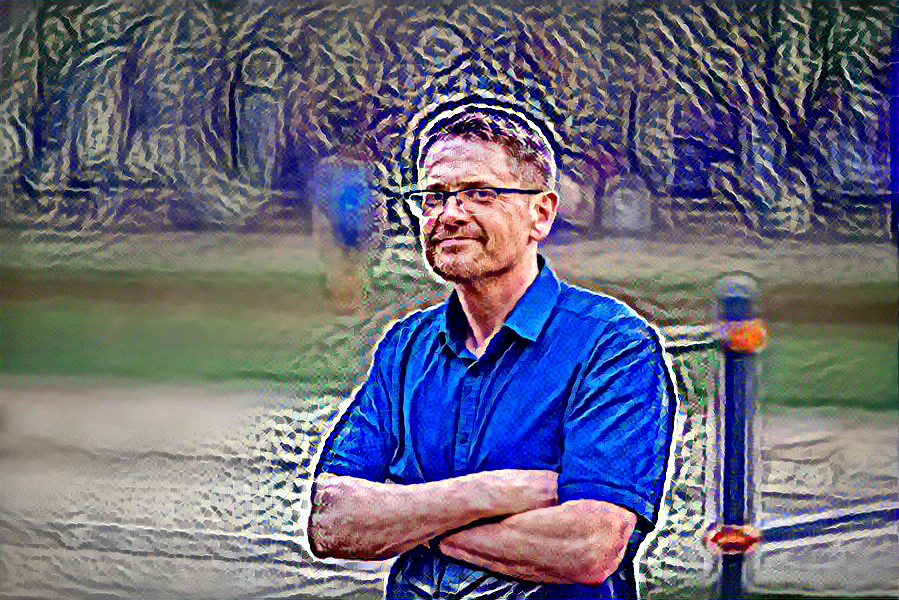

In [44]:
name_image = 'my5.jpg'
name_style = 'Samarkand.jpg'
apply_style_to_image(name_style, name_image, [1., 0.8, 0.5], 'myStyled/' + name_style[:5] + name_image, save = True)

In [46]:
name_style = 'graffiti-569265.jpg'
apply_style_to_image(name_style, name_image, [1., 0.8, 0.5], 'myStyled/' + name_style[:5] + name_image, save = True)

InternalError: ignored

In [ ]:
name_style = 'leaves-3923413.jpg'
apply_style_to_image(name_style, name_image, [1., 0.8, 0.5], 'myStyled/' + name_style[:5] + name_image, save = True)

In [ ]:
name_style = 'pexels-steve-johnson-1183992.jpg'
apply_style_to_image(name_style, name_image, [1., 0.8, 0.5], 'myStyled/' + name_style[:5] + name_image, save = True)

In [ ]:
name_style = 'pattern-2117231.jpg'
apply_style_to_image(name_style, name_image, [1., 0.8, 0.5], 'myStyled/' + name_style[:5] + name_image, save = True)

#Стилизация для одной картинки:


In [380]:
name_style = 'graffiti-569265.jpg'
name_image = 'my8.jpg'

vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [381]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir+'sample styles/', image_dir+'contents-people/']
img_names = [name_style, name_image]
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

opt_img = Variable(content_image.data.clone(), requires_grad=True)

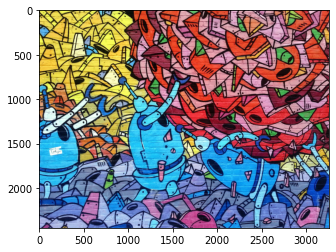

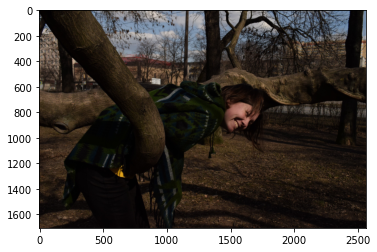

In [382]:
#display images
for img in imgs:
    imshow(img);show()

In [383]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [WeightedMSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e-8/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

content_weight_back = 0.95
content_weight_people = 0.6
content_weight_face = 0.3
#people_mask = get_people_mask(image_dir, name_image)
#face_mask = get_face_mask(image_dir, name_image)
weight_mask = get_weight(content_weight_back, content_weight_people, people_mask, content_weight_face, face_mask)

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [384]:
#save mask
k = 1/(weight_mask.max() - weight_mask.min())
iimm = transforms.ToPILImage()(k-k*weight_mask[0])
iimm.save(image_dir + 'mask/' + name_image)

weight_mask1 = weight_mask.clone().detach()
weight_mask2 = weight_mask.clone().detach()
weight_mask3 = weight_mask.clone().detach()
weight_mask1[weight_mask == content_weight_back] = 0.8
weight_mask2[weight_mask == content_weight_people] = 0.
weight_mask3[weight_mask == content_weight_face] = 0.
color_mask = torch.cat((weight_mask1, weight_mask2, weight_mask3), 1)
iimm = transforms.ToPILImage()(color_mask[0])
iimm.save(image_dir + 'mask-color/' + name_image)

Iteration: 50, loss: 502382.000000
Iteration: 100, loss: 431008.750000
Iteration: 150, loss: 417753.562500
Iteration: 200, loss: 411806.906250


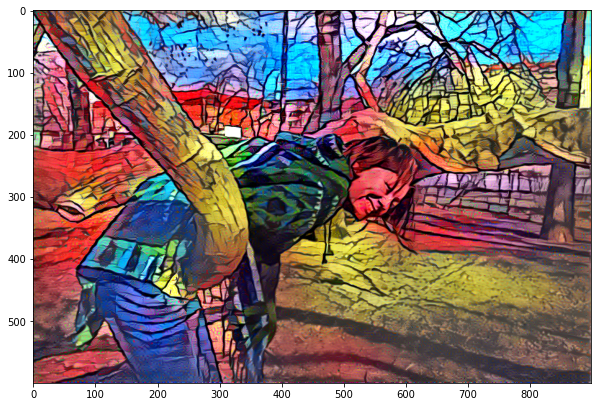

In [385]:
#run style transfer
max_iter = 200
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a], weight_mask = weight_mask) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print(loss)
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
            #print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
out_img.save('/content/gg'+name_style)
imshow(out_img)
gcf().set_size_inches(10,10)

## Ссылка на использованный алгоритм сегментации людей
При модификации - напишите на качественном уровне, в чем была модификация, и ее код.

Метод сегментации:

https://paperswithcode.com/method/deeplabv3

Реализация метода с:

https://pixellib.readthedocs.io/en/latest/Image_pascal.html

## Ссылка на использованный алгоритм сегментации кожи
При модификации - напишите на качественном уровне, в чем была модификация, и ее код.

Метод сегментации:

https://www.semanticscholar.org/paper/Skin-color-segmentation-using-multi-color-space-Rahmat-Chairunnisa/c06873e619c679fd1aa7648a6e402a7d57ea0e20?tab=abstract&citingPapersSort=is-influential&citingPapersLimit=10&citingPapersOffset=0&year%5B0%5D=&year%5B1%5D=&citedPapersSort=is-influential&citedPapersLimit=10&citedPapersOffset=10

Реализация метода с:

https://github.com/WillBrennan/SkinDetector

## Визуализация выбранного стиля

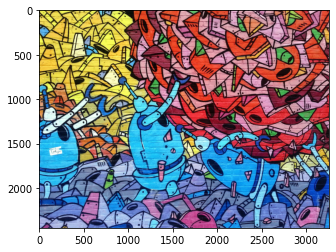

In [ ]:
imshow(imgs[0])
show()

## Таблица изображений для каждого из 32 контентов (64 строки).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

name_style = 'graffiti-569265.jpg'

N_image = 8
fig=plt.figure(figsize=(36, N_image*20))
columns = 3
rows = 2*N_image

for i in range(0,N_image):
  name_image = f'{i+1}.jpg'
  content = plt.imread(image_dir+'contents-people/'+name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+1)
  plt.imshow(content)
  people_mask = plt.imread(image_dir + 'mask/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+2)
  plt.imshow(people_mask)
  face_mask = plt.imread(image_dir + 'mask-color/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+3)
  plt.imshow(face_mask)
  styled_base = plt.imread(image_dir + name_style[:10] + 'contents1/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+4)
  plt.imshow(styled_base)
  styled_mod = plt.imread(image_dir + name_style[:10] + 'contents2/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+5)
  plt.imshow(styled_mod)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
N_image = 8
fig=plt.figure(figsize=(36, N_image*20))
columns = 3
rows = 2*N_image

for i in range(0,N_image):
  name_image = f'{8+i+1}.jpg'
  content = plt.imread(image_dir+'contents-people/'+name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+1)
  plt.imshow(content)
  people_mask = plt.imread(image_dir + 'mask/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+2)
  plt.imshow(people_mask)
  face_mask = plt.imread(image_dir + 'mask-color/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+3)
  plt.imshow(face_mask)
  styled_base = plt.imread(image_dir + name_style[:10] + 'contents1/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+4)
  plt.imshow(styled_base)
  styled_mod = plt.imread(image_dir + name_style[:10] + 'contents2/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+5)
  plt.imshow(styled_mod)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
N_image = 8
fig=plt.figure(figsize=(36, N_image*20))
columns = 3
rows = 2*N_image

for i in range(0,N_image):
  name_image = f'{16+i+1}.jpg'
  content = plt.imread(image_dir+'contents-people/'+name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+1)
  plt.imshow(content)
  people_mask = plt.imread(image_dir + 'mask/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+2)
  plt.imshow(people_mask)
  face_mask = plt.imread(image_dir + 'mask-color/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+3)
  plt.imshow(face_mask)
  styled_base = plt.imread(image_dir + name_style[:10] + 'contents1/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+4)
  plt.imshow(styled_base)
  styled_mod = plt.imread(image_dir + name_style[:10] + 'contents2/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+5)
  plt.imshow(styled_mod)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
N_image = 8
fig=plt.figure(figsize=(36, N_image*20))
columns = 3
rows = 2*N_image

for i in range(0,N_image):
  name_image = f'{24+i+1}.jpg'
  content = plt.imread(image_dir+'contents-people/'+name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+1)
  plt.imshow(content)
  people_mask = plt.imread(image_dir + 'mask/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+2)
  plt.imshow(people_mask)
  face_mask = plt.imread(image_dir + 'mask-color/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+3)
  plt.imshow(face_mask)
  styled_base = plt.imread(image_dir + name_style[:10] + 'contents1/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+4)
  plt.imshow(styled_base)
  styled_mod = plt.imread(image_dir + name_style[:10] + 'contents2/' + name_image, format=None)
  fig.add_subplot(rows, columns, 6*i+5)
  plt.imshow(styled_mod)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Ваши идеи по [alterdraw.com](https://alterdraw.com) (по желанию)
- комментарии по работе алгоритма, идеи улучшения (алгоритм нестандартный, стандартный запатентован)
- улучшение дизайна, дополнительные фичи, опечатки и обнаруженные баги (алгоритм - это лишь 5% от инфраструктуры всего сервиса)
- идеи площадок, где можно было бы продвигать сервис

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
mask > 0